Experiment working with anonymized API log data.

In [1]:
import pandas as pd
%matplotlib inline

from bokeh.io import output_notebook
from bokeh.plotting import figure, show

output_notebook()

Loading BokehJS ...

In [2]:
# Import API logs data
api_logs = pd.read_csv('api_logs.csv', index_col=0, parse_dates=[0])

# Take a look at the columns available
api_logs.columns

Index(['Method', 'Country', 'State', 'City', 'Status', 'Reason Denied',
       'Response Time', 'Content Type', 'Accept Encoding', 'User Agent',
       'Unnamed: 11', 'Unnamed: 12'],
      dtype='object')

In [3]:
# Make sure DataFrame has DatetimeIndex
print(api_logs.index)

DatetimeIndex(['2017-04-25 11:43:48', '2017-04-25 11:43:48',
               '2017-04-25 11:43:48', '2017-04-25 11:45:34',
               '2017-04-25 11:47:39', '2017-04-25 11:46:01',
               '2017-04-25 11:47:20', '2017-04-25 11:46:10',
               '2017-04-25 11:46:17', '2017-04-25 11:44:46',
               ...
               '2017-05-31 07:50:32', '2017-05-31 07:52:05',
               '2017-05-31 08:23:18', '2017-05-31 09:55:25',
               '2017-05-31 09:53:51', '2017-05-31 09:55:31',
               '2017-05-31 10:05:42', '2017-05-31 10:05:50',
               '2017-05-31 10:05:50', '2017-05-31 10:09:36'],
              dtype='datetime64[ns]', name='Time', length=2912, freq=None)


In [4]:
def is_success_function(row):
    """
    Check if row (request) was successful
    Successful means a response with 2xx status
    
    return True if successful False otherwise
    """
    success = (row['Status'] >= 200 and row['Status'] < 300)
    
    if success:
        return 'Success'
    else:
        return 'Failure'
    
# Add 'Success' column to API Logs
# Success is determined by status code, where any status in the 200s is considered successful
api_logs['Outcome'] = api_logs.apply(is_success_function , axis='columns')
api_logs.head()

,Method,Country,State,City,Status,Reason Denied,Response Time,Content Type,Accept Encoding,User Agent,Unnamed: 11,Unnamed: 12,Outcome
Time,,,,,,,,,,,,,
2017-04-25 11:43:48,GET,RU,38,Krasnodar,200,NaN,305,application/json; charset=utf-8,"gzip, deflate, sdch, br",Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_4...,Chrome,Browser,Success
2017-04-25 11:43:48,GET,RU,38,Krasnodar,200,NaN,383,application/json; charset=utf-8,"gzip, deflate, sdch, br",Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_4...,Chrome,Browser,Success
2017-04-25 11:43:48,GET,RU,38,Krasnodar,200,NaN,25,application/json; charset=utf-8,"gzip, deflate, sdch, br",Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_4...,Chrome,Browser,Success
2017-04-25 11:45:34,GET,RU,38,Krasnodar,200,NaN,67,application/json; charset=utf-8,"gzip, deflate, sdch, br",Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_4...,Chrome,Browser,Success
2017-04-25 11:47:39,GET,RU,38,Krasnodar,200,NaN,45,application/json; charset=utf-8,"gzip, deflate, sdch, br",Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_4...,Chrome,Browser,Success


In [5]:
# Export CSV containing Outcome column
api_logs.to_csv('api_logs_with_outcome.csv')

# Explore
Get a feel for the data.

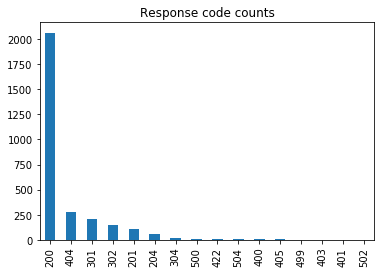

In [6]:
# Check the distribution of statuses in the data
api_response_code_distributions_plot = api_logs['Status'].value_counts().plot('bar', title='Response code counts')

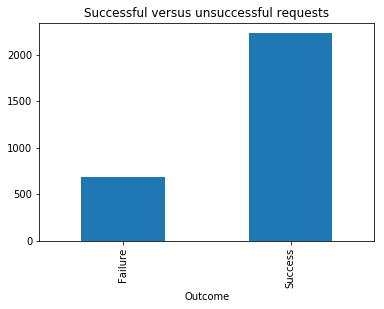

In [7]:
# Compare number of successful versus unsuccessful requests
success_versus_failure = api_logs.groupby('Outcome').size().plot('bar', title='Successful versus unsuccessful requests')

In [8]:
# Group API logs by date and outcome
daily_failure_success_groups = api_logs.groupby([api_logs.index.date, 'Outcome']).size()

# Take a look at the grouped data
daily_failure_success_groups.head()

            Outcome
2017-04-22  Success     7
2017-04-24  Failure    32
            Success    59
2017-04-25  Failure    23
            Success    91
dtype: int64

In [9]:
# Flatten grouped data, so each row has a failure and success column
# Replace NaN numbers with zero (fill_value=0)
success_and_failure_over_time = daily_failure_success_groups.unstack(fill_value=0)

# Take a look at the unstacked data
success_and_failure_over_time.head()

Outcome,Failure,Success
2017-04-22,0,7
2017-04-24,32,59
2017-04-25,23,91
2017-04-26,1,59
2017-04-27,3,1


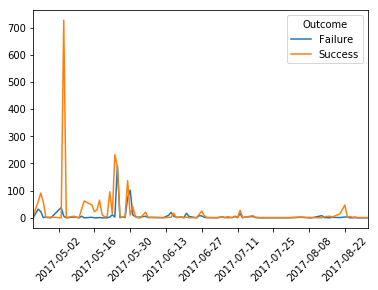

In [10]:
# Plot success and failure countes over time
success_and_failure_chart = success_and_failure_over_time.plot(rot=45)

In [14]:
# create a new plot with a datetime axis type
p = figure(plot_width=800, plot_height=250, x_axis_type="datetime", title="Success and failure over time")

# Add red line showing failure
p.line(success_and_failure_over_time.index, success_and_failure_over_time['Failure'], color='red', alpha=0.5)

# Add green line showing success
p.line(success_and_failure_over_time.index, success_and_failure_over_time['Success'], color='green', alpha=0.5)


# Show the plot
show(p)